In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt
#torch version
torch.__version__

'2.5.1+cu124'

###linear Regression


In [ ]:
#create *known* parameters
weight = 0.7
bias=0.4
#create
start=0
end=1
step=.02
X= torch.arange(start,end,step).unsqueeze(dim=-1)
y= weight*X + bias
X[:10] , y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.4000],
         [0.4140],
         [0.4280],
         [0.4420],
         [0.4560],
         [0.4700],
         [0.4840],
         [0.4980],
         [0.5120],
         [0.5260]]))

In [ ]:
len(X),len(y)

(50, 50)

###splitting data in test and train set


In [ ]:
#create a test train split
train_split = int(0.8*len(X))
train_split

40

In [ ]:
X_train,y_train = X[:train_split], y[:train_split]
X_test,y_test = X[train_split:],y[train_split:]
len(X_train),len(y_train),len(X_test),len(y_test)

(40, 40, 10, 10)

###Better visualization of data

In [ ]:
def plot_predictions(train_data=X_train,train_label=y_train,test_data=X_test,test_label=y_test,predictions=None):
  '''plots tain and test data and compares predictions'''
  plt.figure(figsize=(10,7))
  #plot train data
  plt.scatter(train_data,train_label,c='b',s=4,label='training data')
  #plot test data
  plt.scatter(test_data,test_label,c='g',s=4,label='test data')
  #are there predictions
  if predictions is not None:
    #plot predictions if exist
    plt.scatter(test_data,predictions,c='r',s=4,label='predictions')
  #legends
  plt.legend(prop={'size':14})

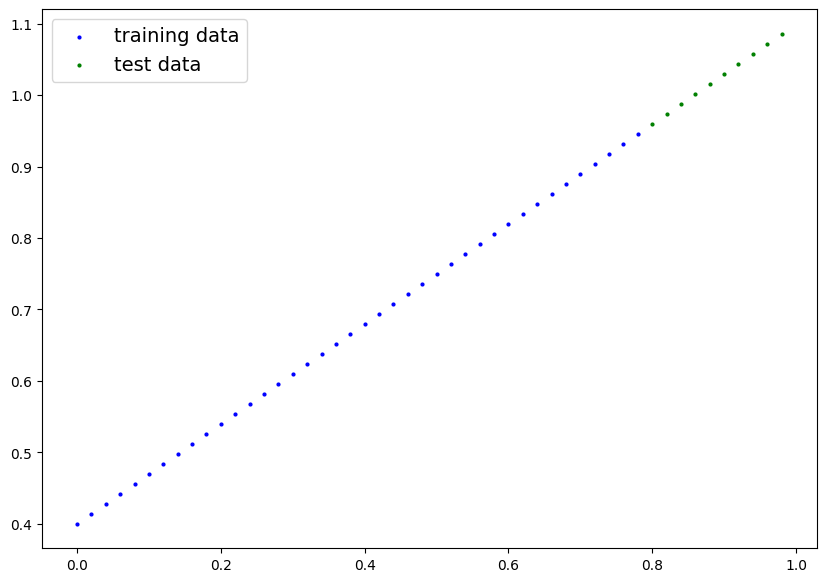

In [ ]:

plot_predictions()

##build model

In [ ]:
class LinearRegression(nn.Module):
  #almost everything in pytorch inherits from nn.module
  def __init__(self):
    super().__init__()
    #weights
    self.weights = nn.Parameter(torch.randn(1#start with a random weight and try to adjust it to ideal weigth
                                            ,requires_grad=True#means pytorch will track the grad of this specific parameter for use with torch.autograd and grad descent
                                            ,dtype=torch.float))
    #bias
    self.bias = nn.Parameter(torch.randn(1,requires_grad=True,dtype=torch.float))
    #create a forward pass
  def forward(self, x:torch.Tensor) -> torch.Tensor:#x is the input data
    return self.weights * x + self.bias

###pytorch model building essentials
torch.nn.Parameter -> Parameters are Tensor subclasses, that have a very special property when used with Module s - when they’re assigned as Module attributes they are automatically added to the list of its parameters, and will appear e.g. in parameters() iterator
                      what params should our model try and learn, often a layer from torch.nn will set these for us.
torch.nn.Module->The base class for all neural network modules, if you subclass it yo should overwrite forward().
torch.optim -> this where the optimizers in pytorch live, they will help with gradinet descent.     
    

In [ ]:
#create a random seed
torch.manual_seed(42)
#create an instance of model, this is a subclass of module
model_0 = LinearRegression()
#check the model parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [ ]:
#list named params
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [ ]:
weight,bias

(0.7, 0.4)

###making predictions using torch.inference_mode()/
to check our model's predictive power, lets see how well it predicts 'y_test' based on 'X_test'.

When we pass our data through our model , its going to run it through 'forward()' method.

In [ ]:
X_test, y_test

(tensor([[0.8000],
         [0.8200],
         [0.8400],
         [0.8600],
         [0.8800],
         [0.9000],
         [0.9200],
         [0.9400],
         [0.9600],
         [0.9800]]),
 tensor([[0.9600],
         [0.9740],
         [0.9880],
         [1.0020],
         [1.0160],
         [1.0300],
         [1.0440],
         [1.0580],
         [1.0720],
         [1.0860]]))

In [ ]:
y_preds = model_0(X_test)
y_preds
#keeps tracks of gradient but while inferencing we are not training so we dont need to keep track so better use inference mode-> faster predictions as no track of grads

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]], grad_fn=<AddBackward0>)

In [ ]:
#make predictions with model
with torch.inference_mode():
  y_preds = model_0(X_test)
#we can also use with torch.no_grad(): however inference mode is preferred
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

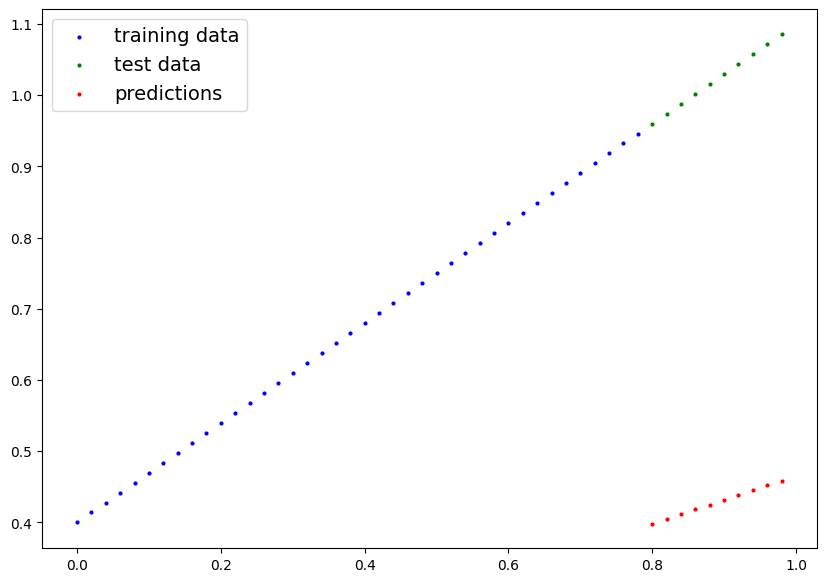

In [ ]:
plot_predictions(predictions=y_preds)

###Train model
the whole idea of training a model is to move from some unknown parameters to some known parameters .
Or in other words from a poor representation of data to a better representation of data .
We can use a loss fuction to check how poor our model performs.
1. **Loss function**: A function to measure how wrong our model's predictions areto ideal output.
2. **Optimizer** : Takes into account the loss of a model and adjusts the model's parameters(eg- weight and biases) to improve the loss function.
3. SPecifically for pytorch -
    a. testing loop
    b. training loop


In [ ]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [ ]:
#check out model parameters(a parameter is a value that the model sets itself)
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [ ]:
#Setup a loss function
loss_fn = nn.L1Loss()
#setup an optimizer
optimizer = torch.optim.SGD(model_0.parameters(), lr = 0.01)#lr = learning rate#hyperparameter - user sets

###Build trainig and testiing loop in pytorch
1. loop through data
2. Forward pass(this involves data moving through our model's 'forward()' functons).
3. calculate the loss(compare forward pass predictions to ground truth labels)
4. optimizer zero grad
5. loss backward - moves backwards through the network to calculate the gradients of the parameters of our model wrt loss
6. optimizer step - use optimizer to adjust our model's params and try improve the loss.

In [ ]:
torch.manual_seed(42)
#an epoch is one loop through the data...(this is a hyperpaaram)
epochs = 100
#track different values
epoch_count = []
loss_values = []
test_loss_values = []
###training
#loop through the data
for epoch in range(epochs):
  #set the model to trainin mode
  model_0.train()#train mode in python sets all parameters that require gradients to require gradients
  #forward pass
  y_pred = model_0(X_train)
  #calculate the loss
  loss = loss_fn(y_pred,y_train)
  #print(f'loss: {loss}')
  #optimizer zero grad
  optimizer.zero_grad()
  #loss backward
  loss.backward()
  #optimizer step(perform grad descent)
  optimizer.step()#by default how the optimizer changes will accumulate through the loop so..we have to zero them above in step 3 for the next iteration of the loop
  ###Tetsing loop
  model_0.eval()#(turns off diff setting in model not needed for evalutaion/testing(dropout/batchNorm.layer))
  with torch.inference_mode():#turns off gradinet tracking anda couple more things behind the scenes
  # with torch.no_grad(): #you may see torch.no_grad in older pytorch code
    # 1. Do the forward pass
    test_pred = model_0(X_test)
    # 2.calculate the loss
    test_loss = loss_fn(test_pred,y_test)
  if epoch % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss}")
    # print out model state_dict()
    print(model_0.state_dict())

Epoch: 0 | Loss: 0.41288137435913086 | Test Loss: 0.5810651779174805
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 10 | Loss: 0.2976713180541992 | Test Loss: 0.4463551640510559
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch: 20 | Loss: 0.18246141076087952 | Test Loss: 0.3116453289985657
OrderedDict([('weights', tensor([0.4186])), ('bias', tensor([0.3388]))])
Epoch: 30 | Loss: 0.07432593405246735 | Test Loss: 0.18313124775886536
OrderedDict([('weights', tensor([0.4574])), ('bias', tensor([0.4328]))])
Epoch: 40 | Loss: 0.04388336092233658 | Test Loss: 0.11712293326854706
OrderedDict([('weights', tensor([0.4888])), ('bias', tensor([0.4708]))])
Epoch: 50 | Loss: 0.03826197236776352 | Test Loss: 0.0926765650510788
OrderedDict([('weights', tensor([0.5107])), ('bias', tensor([0.4758]))])
Epoch: 60 | Loss: 0.034725259989500046 | Test Loss: 0.08165650069713593
OrderedDict([('weights', tensor([0.5287])), ('bias', tensor([0.4708]))

In [ ]:
import numpy as np
epoch_count,np.array(torch.tensor(loss_values).numpy()),test_loss_values

([0, 10, 20, 30, 40, 50, 60, 70, 80, 90],
 array([0.41288137, 0.29767132, 0.18246141, 0.07432593, 0.04388336,
        0.03826197, 0.03472526, 0.03126086, 0.02783176, 0.02439604],
       dtype=float32),
 [tensor(0.5811),
  tensor(0.4464),
  tensor(0.3116),
  tensor(0.1831),
  tensor(0.1171),
  tensor(0.0927),
  tensor(0.0817),
  tensor(0.0720),
  tensor(0.0644),
  tensor(0.0562)])

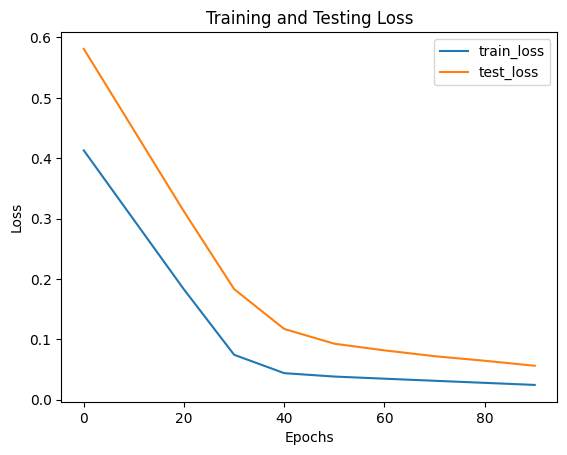

In [ ]:
#plot the loss curves
plt.plot(epoch_count,np.array(torch.tensor(loss_values).numpy()),label='train_loss')
plt.plot(epoch_count,test_loss_values,label='test_loss')
plt.title('Training and Testing Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend();

In [ ]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

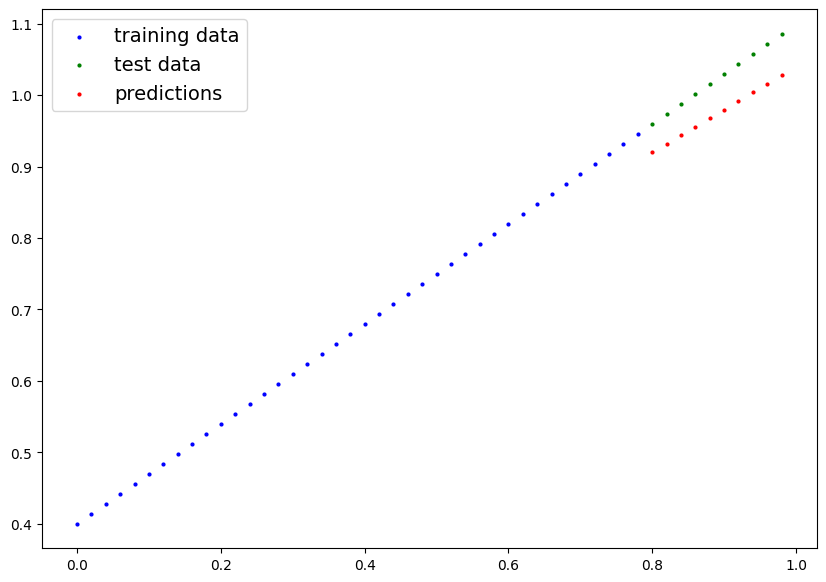

In [ ]:
plot_predictions(predictions=y_preds_new)

###Saving a model in pytorch

There are 3 methods->
1. 'torch.save()'-allows you to save a pytorch object in pickle format.
2. 'torch.load()'-allows you to load a save pytorch object.
3. 'torch.nn.Module.load_state_dict()'-allows you to load a model's saved state dictionary




In [ ]:
#saving our pytorch model
from pathlib import Path
#1.Create models directory
MODEL_PATH  = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)
#2. Create model save path
MODEL_NAME = '01_pytorch_workflow_model.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
#3. save the model state dict()
print(f'saving model to: {MODEL_SAVE_PATH}')
torch.save(obj=model_0.state_dict(),f=MODEL_SAVE_PATH)

saving model to: models/01_pytorch_workflow_model.pth


In [ ]:
!ls -l models

total 8
-rw-r--r-- 1 root root 1744 Feb 18 22:14 01_pytorch_workflow_model_1.pth
-rw-r--r-- 1 root root 1668 Feb 18 22:15 01_pytorch_workflow_model.pth


In [ ]:
#Loading a pytorch model
# to load in a saved state_dict() we have to instantiate a new instance of our model class
loaded_model_0 = LinearRegression()
#load the saved state dict of model_0(this will update the new instance with updated parameters)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<ipython-input-64-90f9641554da>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


<All keys matched successfully>

In [ ]:
loaded_model_0.state_dict()
#

OrderedDict([('weights', tensor([0.5957])), ('bias', tensor([0.4438]))])

In [ ]:
#make some predictions with our loaded model
loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)
loaded_model_preds

tensor([[0.9204],
        [0.9323],
        [0.9442],
        [0.9561],
        [0.9681],
        [0.9800],
        [0.9919],
        [1.0038],
        [1.0157],
        [1.0276]])

In [ ]:
#make some model preds
model_0.eval()
with torch.inference_mode():
  y_model_preds = model_0(X_test)
y_model_preds

tensor([[0.9204],
        [0.9323],
        [0.9442],
        [0.9561],
        [0.9681],
        [0.9800],
        [0.9919],
        [1.0038],
        [1.0157],
        [1.0276]])

In [ ]:
#compare loaded model preds with original model preds
#y_preds == loaded_model_preds

#Putting it all together


In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt
torch.__version__

'2.5.1+cu124'


create device agnostic code.
This means if we got access to  GPU our code will use it

If no GPU available , the code will default to using CPU


In [ ]:
#Setup Device agnostic code
device = "cuda" if torch.cuda.is_available() else "CPU"
print(f"Using device:{device} ")

Using device:CPU 


In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


###1.1 data

In [ ]:
#create some data using linear regresion
weight = 0.7
bias = 0.3
#Create Features
X = torch.arange(0,1,0.02).unsqueeze(dim=1)
y = weight * X + bias
X[:10],y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [ ]:
#Split data
train_split = int(0.8*len(X))
X_train , y_train= X[:train_split],y[:train_split]
X_test,y_test = X[train_split:],y[train_split:]
len(X_train),len(y_train),len(X_test),len(y_test)

(40, 40, 10, 10)

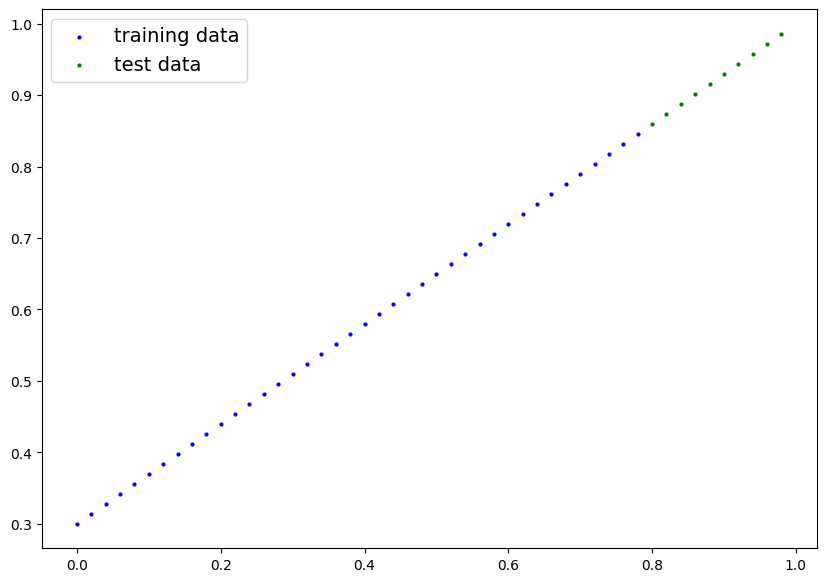

In [ ]:
#Plot data
plot_predictions(X_train,y_train,X_test,y_test)

##1#.2 Build a linear model




In [ ]:
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    #use nn.Linear for creating the model params
    self.linear_layer= nn.Linear(1,1)
  def forward(self,x:torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)
#set manual seed
torch.manual_seed(3301)
#create an instance of our model
model_1 = LinearRegressionModel()
model_1,model_1.state_dict()

(LinearRegressionModel(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[-0.8901]])),
              ('linear_layer.bias', tensor([0.9111]))]))

In [ ]:
X_train[:5],y_train[:5]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560]]))

In [ ]:
#check device
next(model_1.parameters()).device

device(type='cpu')

In [ ]:
#SEt the model to use target device
# model_1.to(device)
# next(model_1.parameters()).device

In [ ]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[-0.8901]])),
             ('linear_layer.bias', tensor([0.9111]))])

##1.3 Training loop

In [ ]:
#setup a loss fuction
loss_fn = nn.L1Loss()
#setup an optimizer
optimizer = torch.optim.Adam(params=model_1.parameters(),lr=0.01)


In [ ]:
torch.manual_seed(3301)

In [ ]:
epochs=200
for epoch in range(epochs):
  model_1.train()
  y_pred = model_1(X_train)
  #calculate the loss
  loss = loss_fn(y_pred,y_train)
  #optimizer zero_grad
  optimizer.zero_grad()
  #loss backward
  loss.backward()
  #optimizer step
  optimizer.step()
  model_1.eval()
  ###TESTING
  model_1.eval()
  with torch.inference_mode():
    test_pred = model_1(X_test)
    test_loss = loss_fn(test_pred,y_test)
    #print
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss}")

Epoch: 0 | Loss: 0.31801509857177734 | Test Loss: 0.7978572249412537
Epoch: 10 | Loss: 0.29801517724990845 | Test Loss: 0.7359989285469055
Epoch: 20 | Loss: 0.27805569767951965 | Test Loss: 0.6766058206558228
Epoch: 30 | Loss: 0.2581261396408081 | Test Loss: 0.632461667060852
Epoch: 40 | Loss: 0.23819255828857422 | Test Loss: 0.5803709626197815
Epoch: 50 | Loss: 0.2182779759168625 | Test Loss: 0.5325733423233032
Epoch: 60 | Loss: 0.19833210110664368 | Test Loss: 0.48006826639175415
Epoch: 70 | Loss: 0.17845799028873444 | Test Loss: 0.4322565495967865
Epoch: 80 | Loss: 0.15848085284233093 | Test Loss: 0.3861057758331299
Epoch: 90 | Loss: 0.13854357600212097 | Test Loss: 0.3364109396934509
Epoch: 100 | Loss: 0.1185896024107933 | Test Loss: 0.28449350595474243
Epoch: 110 | Loss: 0.09865818172693253 | Test Loss: 0.23906144499778748
Epoch: 120 | Loss: 0.07871507853269577 | Test Loss: 0.1892348825931549
Epoch: 130 | Loss: 0.0587628073990345 | Test Loss: 0.13827860355377197
Epoch: 140 | Loss:

In [ ]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6987]])),
             ('linear_layer.bias', tensor([0.2969]))])

###1.4 Making and Evaluating predictions

In [ ]:
model_1.eval()
#make prediction on test data
with torch.inference_mode():
  y_preds = model_1(X_test)
y_preds

tensor([[0.8559],
        [0.8699],
        [0.8839],
        [0.8978],
        [0.9118],
        [0.9258],
        [0.9398],
        [0.9537],
        [0.9677],
        [0.9817]])

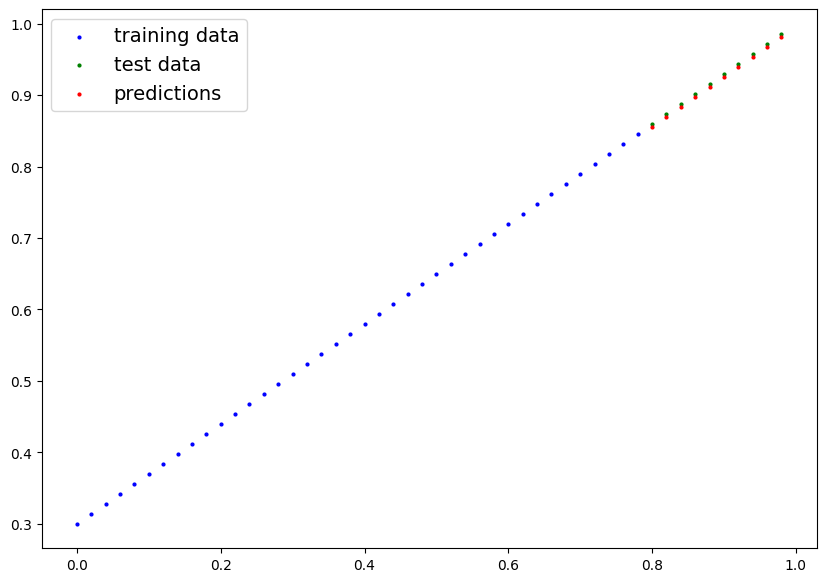

In [ ]:
plot_predictions(X_train,y_train,X_test,y_test,y_preds)
#

###1.5 saving model

In [ ]:
from pathlib import Path
Model_path = Path('models')
Model_path.mkdir(parents=True,exist_ok=True)
MODEL_NAME = '01_pytorch_workflow_model_1.pth'
MODEL_SAVE_PATH = Model_path / MODEL_NAME
print(f'saving model to: {MODEL_SAVE_PATH}')
torch.save(obj=model_1.state_dict(),f=MODEL_SAVE_PATH)

saving model to: models/01_pytorch_workflow_model_1.pth


In [ ]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6987]])),
             ('linear_layer.bias', tensor([0.2969]))])

In [ ]:
loaded_model_1 = LinearRegressionModel()
loaded_model_1.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


<ipython-input-90-554202f99e25>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_1.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


<All keys matched successfully>

In [ ]:
next(loaded_model_1.parameters()).device

device(type='cpu')

In [ ]:
loaded_model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6987]])),
             ('linear_layer.bias', tensor([0.2969]))])

In [ ]:
#EVluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
  loaded_model_1_preds = loaded_model_1(X_test)
y_preds==loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])